In [1]:
from analyze_modes import *

nsVT and ACA overlap: 2
VT and ACA overlap: 0
VT and nsVT overlap: 2
All three overlap: 0
              M1        M2        M3        M4        M5        M6        M7  \
p-value  0.02146  0.004208  0.756559  0.588712  0.778583  0.057951  0.670579   

               M8        M9       M10  
p-value  0.013956  0.187064  0.466524  


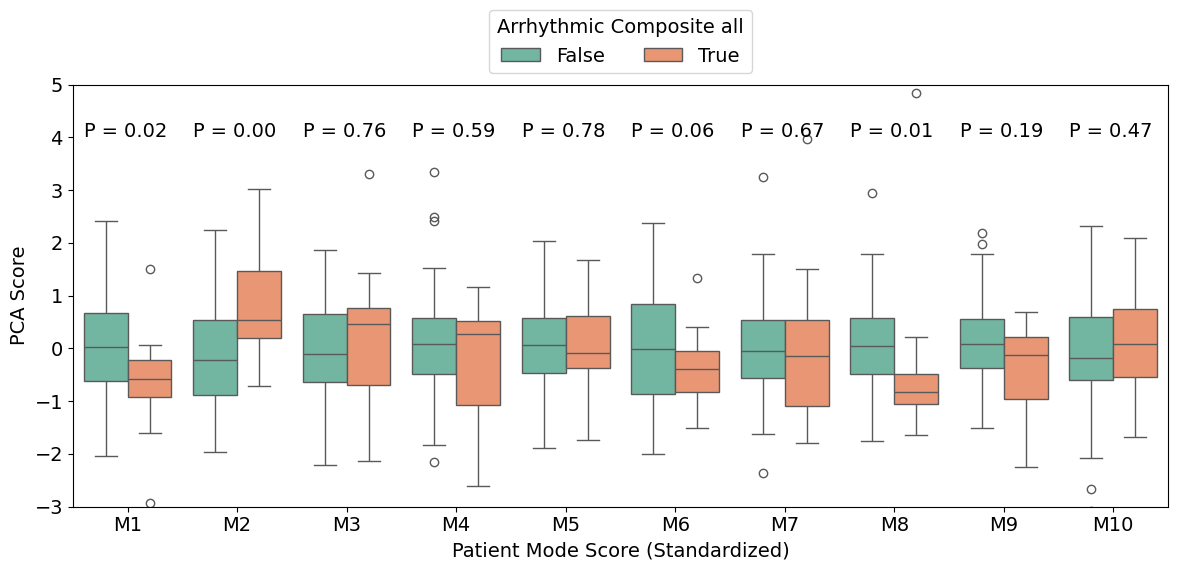

In [4]:
CLINICAL_DATA_XL = "/Users/au698484/Documents/SSCP25_data/Data and scripts SSCP25/utils/ClinicalData_OUS_MADPatients_EIVIND_29_4_2021.xlsx"
PCA_SCORES_CSV = "/Users/au698484/Documents/sscp25/PCA_results/pca_scores.csv"
NUM_MODES = 10

run_analysis_arrhythmia(CLINICAL_DATA_XL, PCA_SCORES_CSV, NUM_MODES)

               M1        M2        M3        M4        M5        M6        M7  \
p-value  0.324527  0.278271  0.666676  0.221393  0.747606  0.339329  0.448773   

               M8        M9       M10  
p-value  0.785399  0.529517  0.885839  


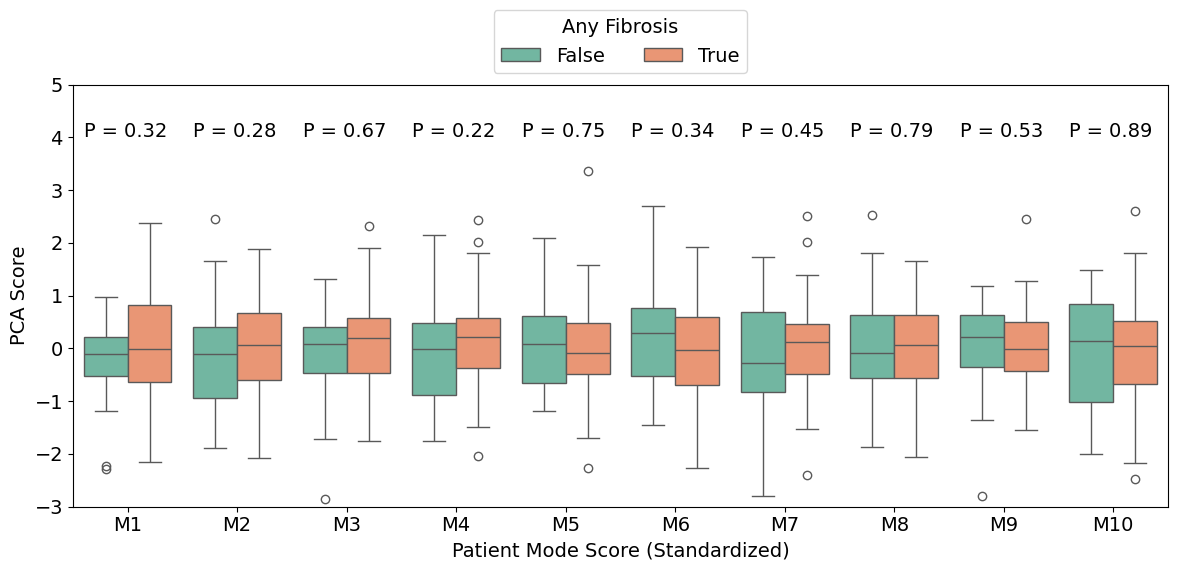

In [3]:
run_analysis_fibrosis(CLINICAL_DATA_XL, PCA_SCORES_CSV, NUM_MODES)

               M1        M2        M3        M4       M5        M6        M7  \
p-value  0.633701  0.123544  0.187145  0.226826  0.05065  0.316638  0.113762   

              M8        M9       M10  
p-value  0.38799  0.372987  0.365622  


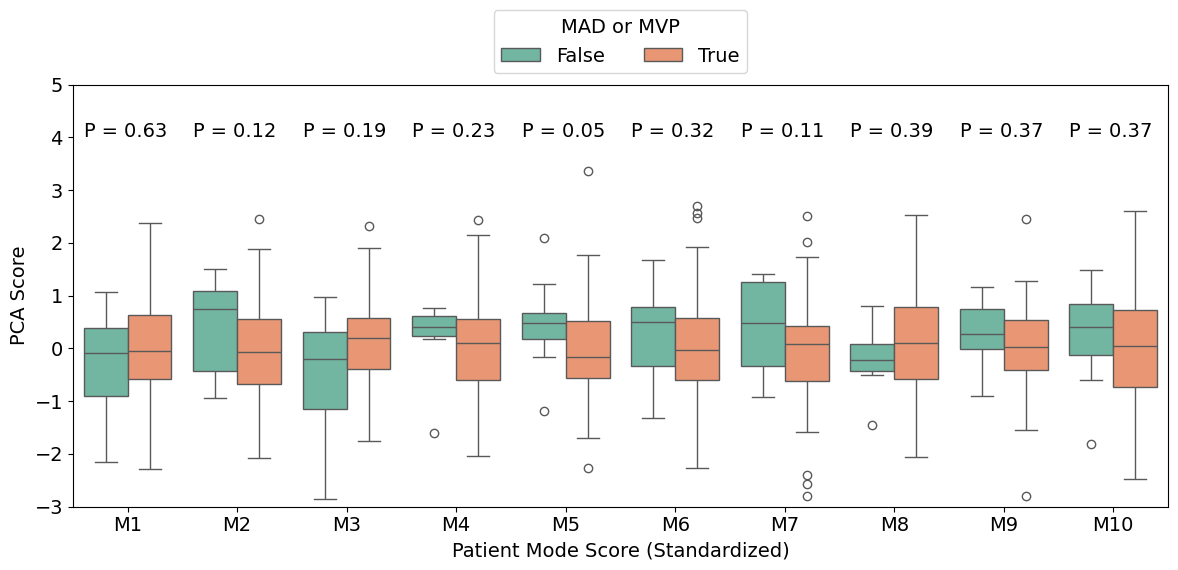

In [4]:
run_analysis_mad(CLINICAL_DATA_XL, PCA_SCORES_CSV, NUM_MODES)

# Look at sex-differences

nsVT and ACA overlap: 1
VT and ACA overlap: 0
VT and nsVT overlap: 1
All three overlap: 0
               M1        M2        M3        M4        M5        M6        M7  \
p-value  0.005612  0.894993  0.011337  0.817282  0.691825  0.181084  0.091932   

               M8   M9       M10  
p-value  0.716396  1.0  0.620035  


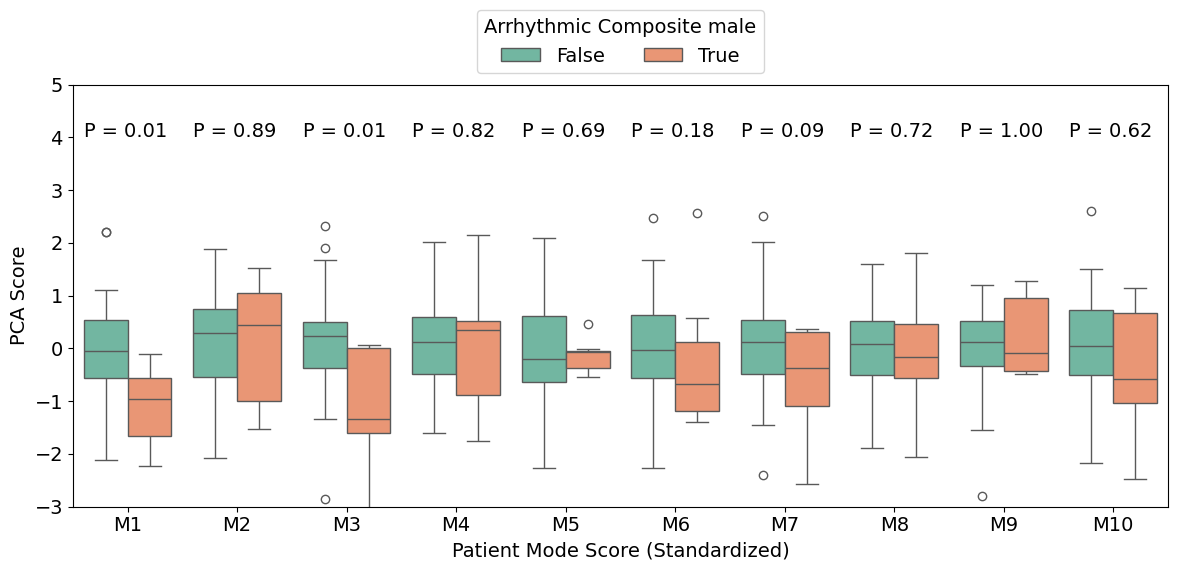

              M1        M2        M3        M4        M5        M6        M7  \
p-value  0.61473  0.182744  0.067878  0.107684  0.744662  0.447294  0.483479   

               M8        M9       M10  
p-value  0.820429  0.944922  0.929222  


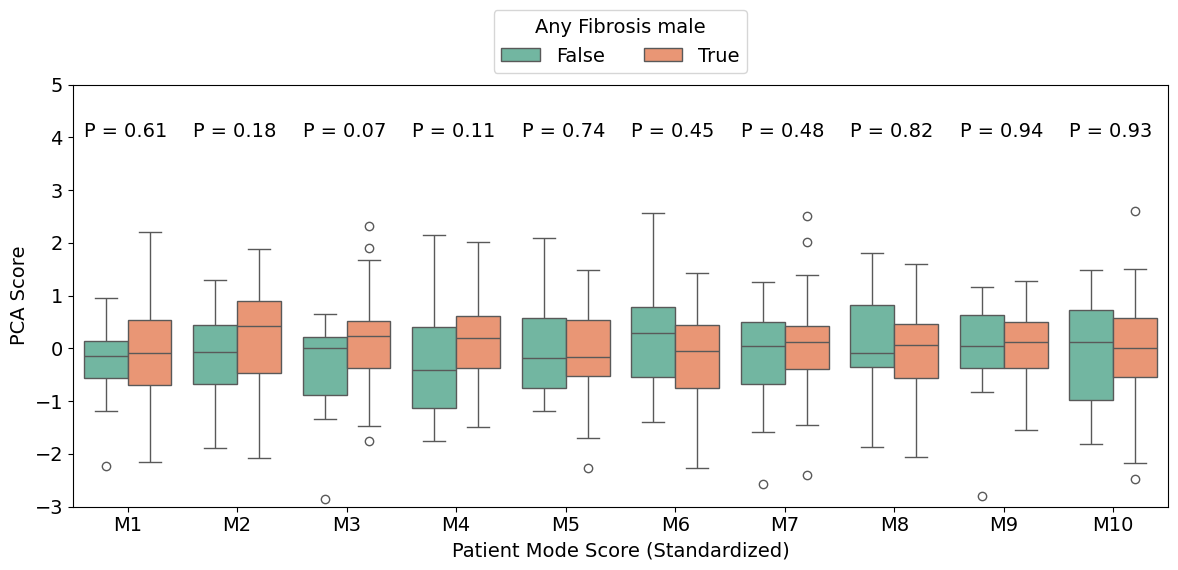

               M1        M2        M3        M4        M5        M6        M7  \
p-value  0.464958  0.143003  0.077288  0.205328  0.077288  0.408046  0.106333   

               M8        M9       M10  
p-value  0.541672  0.196644  0.658302  


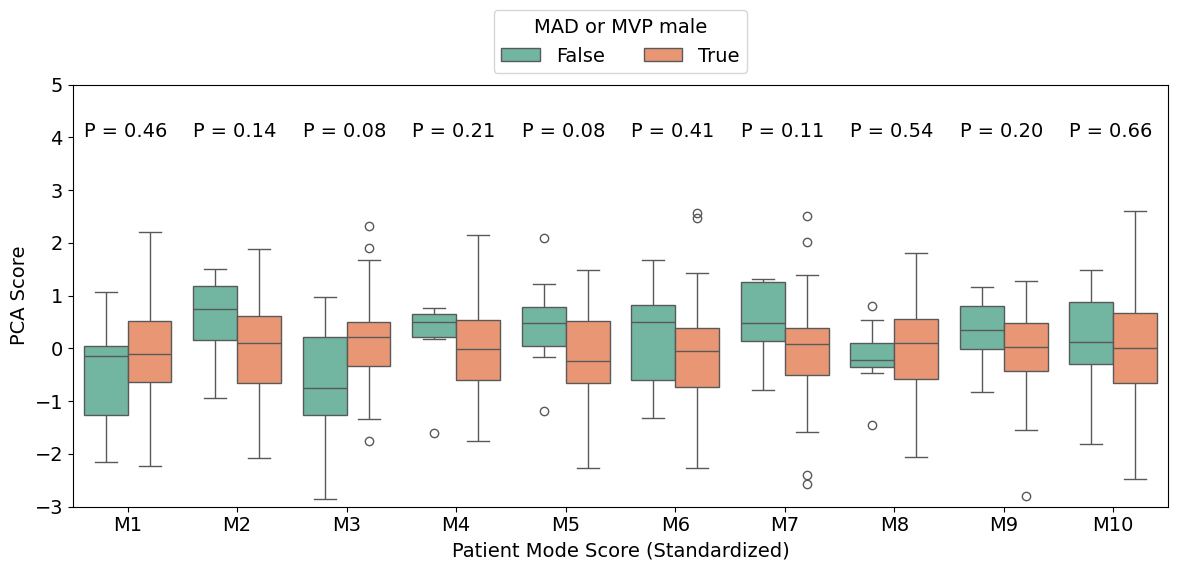

nsVT and ACA overlap: 1
VT and ACA overlap: 0
VT and nsVT overlap: 1
All three overlap: 0
               M1        M2        M3        M4        M5        M6        M7  \
p-value  0.844865  0.715961  0.088956  0.031864  0.844865  0.018947  0.351867   

               M8        M9       M10  
p-value  0.844865  0.129022  0.555699  


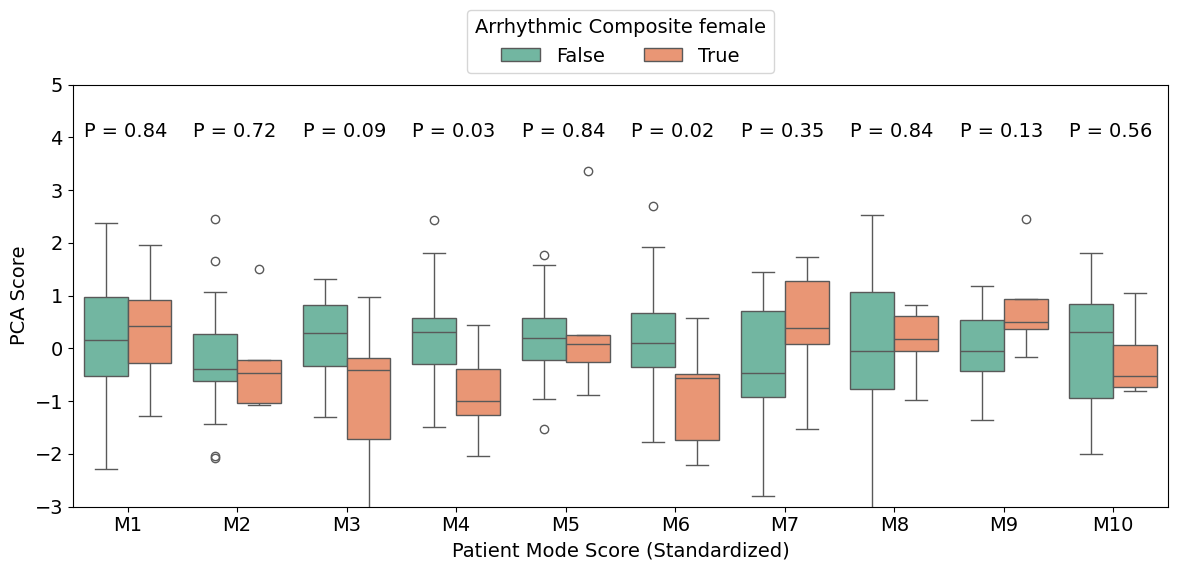

               M1        M2        M3        M4        M5       M6        M7  \
p-value  0.194347  0.912421  0.152772  0.947385  0.367121  0.58237  0.843066   

               M8        M9       M10  
p-value  0.612904  0.441361  0.741433  


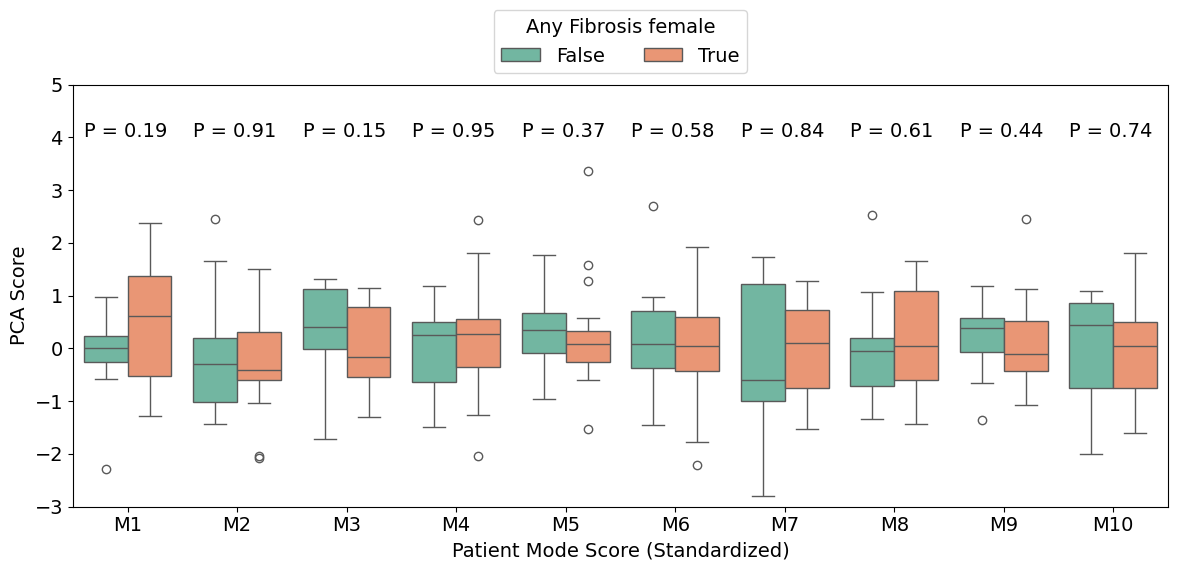

               M1        M2        M3        M4        M5        M6        M7  \
p-value  0.606897  0.901149  0.777011  0.965517  0.294253  0.556322  0.717241   

               M8        M9       M10  
p-value  0.662069  0.606897  0.372414  


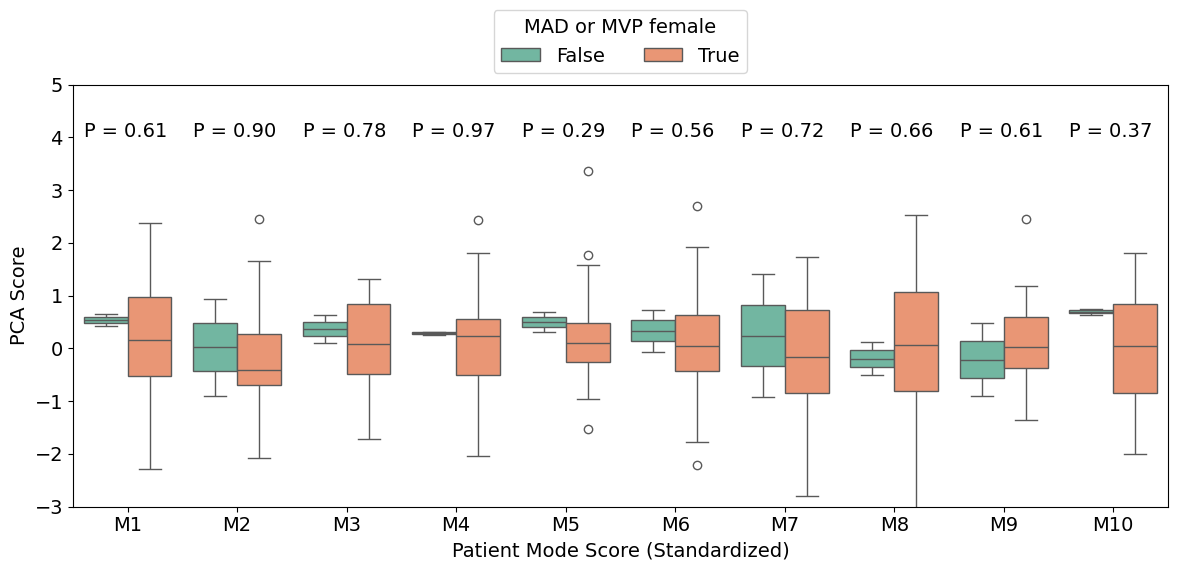

In [3]:
for sex in ["male", "female"]:
    run_analysis_arrhythmia(CLINICAL_DATA_XL, PCA_SCORES_CSV, NUM_MODES, sex=sex)
    run_analysis_fibrosis(CLINICAL_DATA_XL, PCA_SCORES_CSV, NUM_MODES, sex=sex)
    run_analysis_mad(CLINICAL_DATA_XL, PCA_SCORES_CSV, NUM_MODES, sex=sex)


# Continuous Variables

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from scipy import stats
import os
import statsmodels.api as sm

In [6]:
def load_pca_scores(file_path):
    """Loads and standardizes PCA scores from a CSV file."""
    try:
        pca_scores = pd.read_csv(file_path).set_index("Pat_no")
        pca_scores.index = pca_scores.index.astype(int)
        pca_scores = (pca_scores - pca_scores.mean()) / pca_scores.std()
        return pca_scores
    except Exception as e:
        print(f"Error loading file {file_path}: {e}")
        return None
    
def load_patient_data(file_path):
    """Loads patient clinical data from an Excel file."""
    try:
        data = pd.read_excel(file_path).drop([0, 1])
        data["Pat_no"] = data["Pat_no"].astype(int)
        data.set_index("Pat_no", inplace=True)
        return data
    except Exception as e:
        print(f"Error loading file {file_path}: {e}")
        return None

In [7]:

def plot_pca_vs_clinical(pca_scores, mode_name, clinical_data, clinical_var, clinical_label=None):
    """
    Compare PCA scores for a given mode with a clinical continuous variable.

    Parameters
    ----------
    pca_scores : pd.DataFrame
        DataFrame with PCA scores, columns like "M1", "M2", ...
    mode_name : str
        The PCA mode to analyze (e.g., "M1").
    clinical_data : pd.DataFrame
        DataFrame with clinical variables.
    clinical_var : str
        Column name in clinical_data for the continuous variable.
    clinical_label : str, optional
        Human-readable label for axis/title. Defaults to column name.
    """

    if clinical_label is None:
        clinical_label = clinical_var

    # Extract relevant series
    y_data = pca_scores[mode_name]
    x_data = clinical_data[clinical_var]

    # Find common patients
    common_patients = x_data.index.intersection(y_data.index)

    # Subset & clean - This drops all NaN values, so if they should be filled in with a default value this needs to be changed
    df = pd.DataFrame({
        clinical_label: x_data.loc[common_patients],
        "PCA_Score": y_data.loc[common_patients]
    }).replace([np.inf, -np.inf], np.nan).dropna()

    # Prepare for regression
    X = sm.add_constant(df[clinical_label])  
    Y = df["PCA_Score"]

    # Fit OLS model
    model = sm.OLS(Y, X).fit()
    r_squared = model.rsquared
    print(f"\n--- Regression: {mode_name} vs {clinical_label} ---")
    print(model.summary())

    # Plot
    plt.figure(figsize=(8, 5))
    plt.scatter(df[clinical_label], df["PCA_Score"], label='Data points', color='steelblue')
    plt.plot(df[clinical_label], model.predict(X), color='red', label='Regression line')
    plt.xlabel(clinical_label)
    plt.ylabel(f"PCA Score {mode_name}")
    plt.title(f"{clinical_label} vs PCA {mode_name}")
    plt.text(
        x=df[clinical_label].min(), 
        y=df["PCA_Score"].max(), 
        s=f'$R^2 = {r_squared:.3f}$',
        fontsize=12,
        color='darkred',
        verticalalignment='top'
    )
    plt.legend()
    plt.tight_layout()
    plt.show()


In [ ]:
CLINICAL_DATA_XL = "/Users/au698484/Documents/SSCP25_data/Data and scripts SSCP25/utils/ClinicalData_OUS_MADPatients_EIVIND_29_4_2021.xlsx"
PCA_SCORES_CSV = "/Users/au698484/Documents/motion-analysis/PCA_results_motion/pca_scores.csv"
NUM_MODES = 10

pca_scores = load_pca_scores(PCA_SCORES_CSV)
clinical_data = load_patient_data(CLINICAL_DATA_XL)


--- Regression: M1 vs Percentage of myocardium with fibrosis ---
                            OLS Regression Results                            
Dep. Variable:              PCA_Score   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                 -0.009
Method:                 Least Squares   F-statistic:                    0.4386
Date:                Fri, 08 Aug 2025   Prob (F-statistic):              0.510
Time:                        13:43:41   Log-Likelihood:                -95.709
No. Observations:                  67   AIC:                             195.4
Df Residuals:                      65   BIC:                             199.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                             coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------

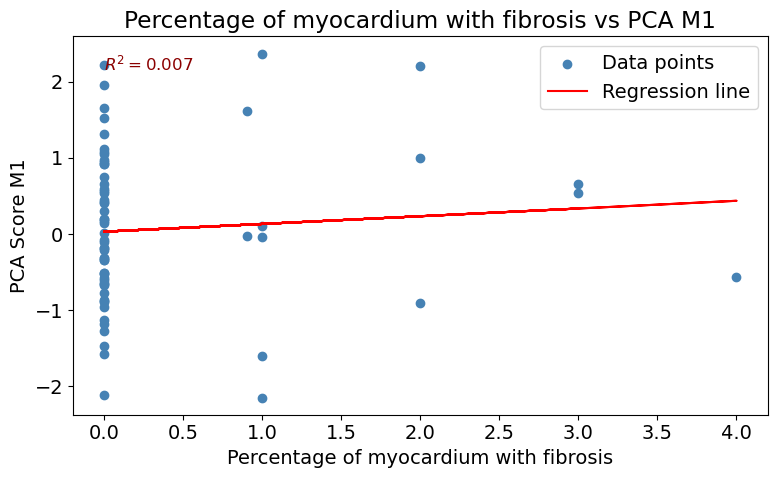


--- Regression: M2 vs Percentage of myocardium with fibrosis ---
                            OLS Regression Results                            
Dep. Variable:              PCA_Score   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.015
Method:                 Least Squares   F-statistic:                   0.04473
Date:                Fri, 08 Aug 2025   Prob (F-statistic):              0.833
Time:                        13:43:41   Log-Likelihood:                -94.313
No. Observations:                  67   AIC:                             192.6
Df Residuals:                      65   BIC:                             197.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                             coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------

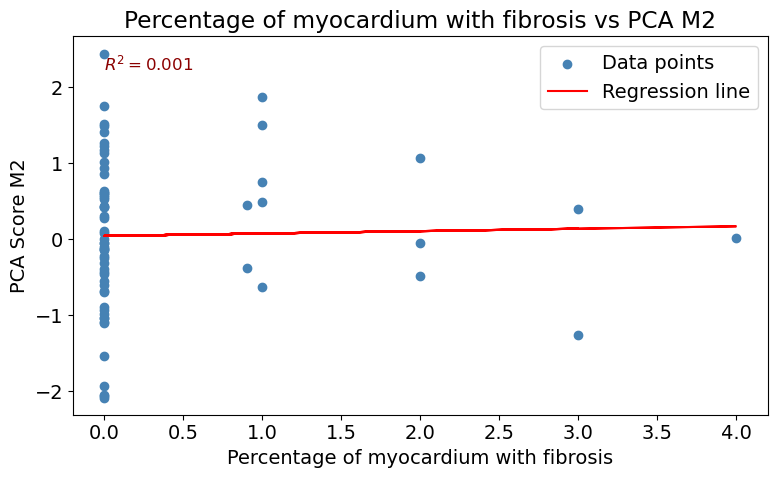


--- Regression: M3 vs Percentage of myocardium with fibrosis ---
                            OLS Regression Results                            
Dep. Variable:              PCA_Score   R-squared:                       0.022
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     1.448
Date:                Fri, 08 Aug 2025   Prob (F-statistic):              0.233
Time:                        13:43:41   Log-Likelihood:                -86.498
No. Observations:                  67   AIC:                             177.0
Df Residuals:                      65   BIC:                             181.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                             coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------

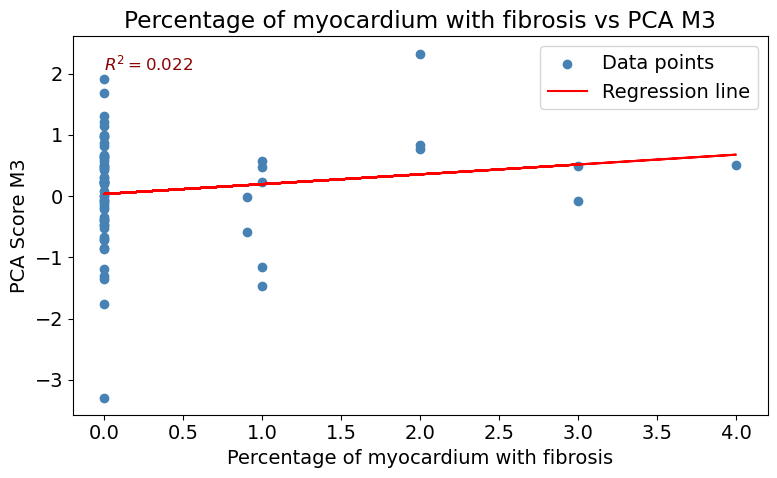


--- Regression: M4 vs Percentage of myocardium with fibrosis ---
                            OLS Regression Results                            
Dep. Variable:              PCA_Score   R-squared:                       0.022
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     1.485
Date:                Fri, 08 Aug 2025   Prob (F-statistic):              0.227
Time:                        13:43:41   Log-Likelihood:                -82.878
No. Observations:                  67   AIC:                             169.8
Df Residuals:                      65   BIC:                             174.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                             coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------

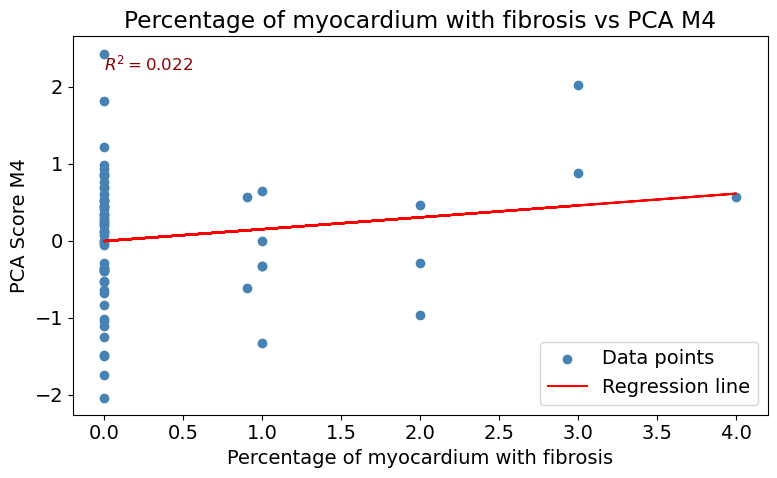


--- Regression: M5 vs Percentage of myocardium with fibrosis ---
                            OLS Regression Results                            
Dep. Variable:              PCA_Score   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                 -0.010
Method:                 Least Squares   F-statistic:                    0.3419
Date:                Fri, 08 Aug 2025   Prob (F-statistic):              0.561
Time:                        13:43:41   Log-Likelihood:                -86.069
No. Observations:                  67   AIC:                             176.1
Df Residuals:                      65   BIC:                             180.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                             coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------

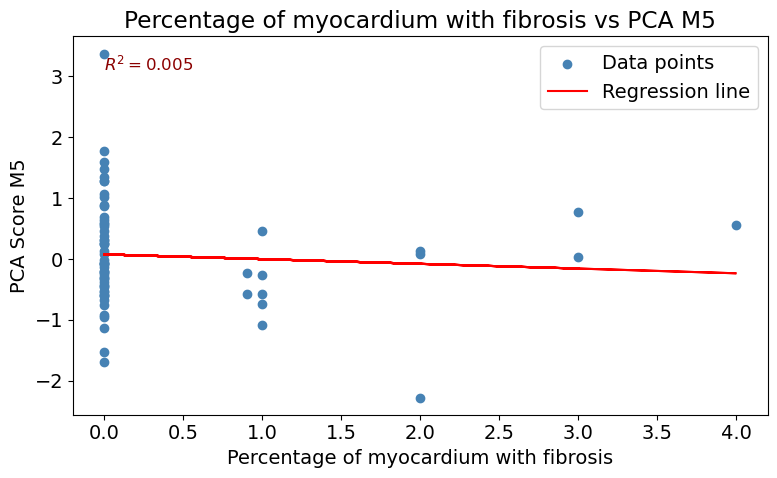


--- Regression: M6 vs Percentage of myocardium with fibrosis ---
                            OLS Regression Results                            
Dep. Variable:              PCA_Score   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.015
Method:                 Least Squares   F-statistic:                  0.008271
Date:                Fri, 08 Aug 2025   Prob (F-statistic):              0.928
Time:                        13:43:41   Log-Likelihood:                -91.247
No. Observations:                  67   AIC:                             186.5
Df Residuals:                      65   BIC:                             190.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                             coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------

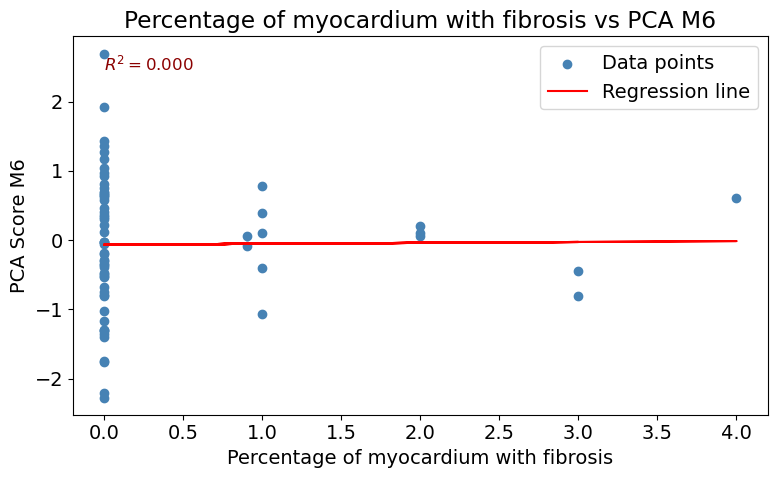

In [11]:
# Loop over PCA modes
for mode in ["M1", "M2", "M3", "M4", "M5", "M6"]:
    plot_pca_vs_clinical(
        pca_scores=pca_scores,
        mode_name=mode,
        clinical_data=clinical_data,
        clinical_var="CMR_LGE_Myocardium_percent",
        clinical_label="Percentage of myocardium with fibrosis"
    )


--- Regression: M1 vs  Volume of fibrosis in adjacent myocardium (mL) ---
                            OLS Regression Results                            
Dep. Variable:              PCA_Score   R-squared:                       0.187
Model:                            OLS   Adj. R-squared:                  0.129
Method:                 Least Squares   F-statistic:                     3.218
Date:                Fri, 08 Aug 2025   Prob (F-statistic):             0.0944
Time:                        13:43:46   Log-Likelihood:                -17.325
No. Observations:                  16   AIC:                             38.65
Df Residuals:                      14   BIC:                             40.20
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                                      coef    std err          t      P>|t|      [0.025      0.975]
-------------------

/opt/homebrew/Caskroom/miniconda/base/lib/python3.13/site-packages/scipy/stats/_axis_nan_policy.py:430: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=16 observations were given.
  return hypotest_fun_in(*args, **kwds)


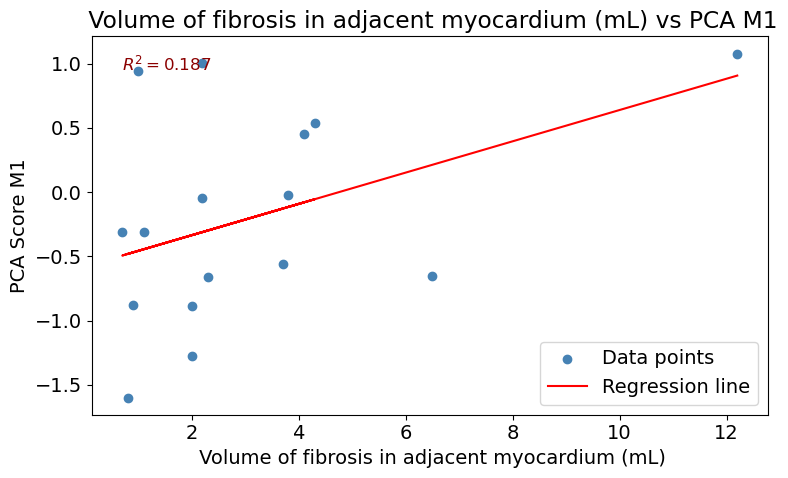


--- Regression: M2 vs  Volume of fibrosis in adjacent myocardium (mL) ---
                            OLS Regression Results                            
Dep. Variable:              PCA_Score   R-squared:                       0.019
Model:                            OLS   Adj. R-squared:                 -0.051
Method:                 Least Squares   F-statistic:                    0.2666
Date:                Fri, 08 Aug 2025   Prob (F-statistic):              0.614
Time:                        13:43:46   Log-Likelihood:                -20.228
No. Observations:                  16   AIC:                             44.46
Df Residuals:                      14   BIC:                             46.00
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                                      coef    std err          t      P>|t|      [0.025      0.975]
-------------------

/opt/homebrew/Caskroom/miniconda/base/lib/python3.13/site-packages/scipy/stats/_axis_nan_policy.py:430: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=16 observations were given.
  return hypotest_fun_in(*args, **kwds)


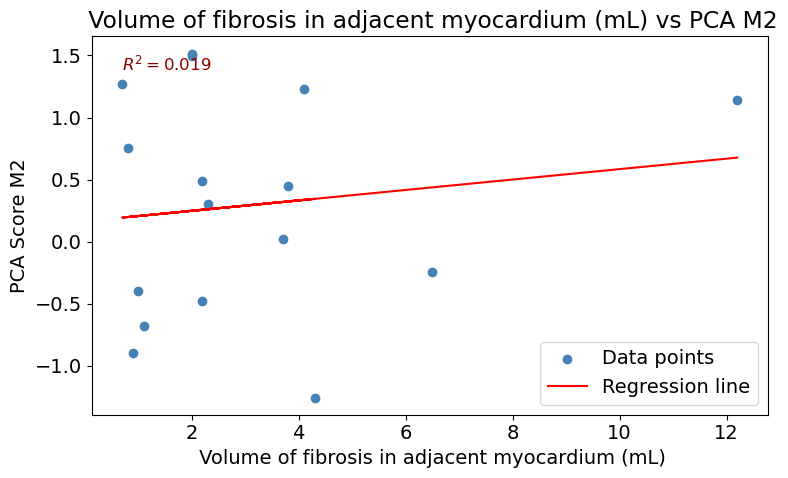


--- Regression: M3 vs  Volume of fibrosis in adjacent myocardium (mL) ---
                            OLS Regression Results                            
Dep. Variable:              PCA_Score   R-squared:                       0.109
Model:                            OLS   Adj. R-squared:                  0.045
Method:                 Least Squares   F-statistic:                     1.714
Date:                Fri, 08 Aug 2025   Prob (F-statistic):              0.212
Time:                        13:43:46   Log-Likelihood:                -21.518
No. Observations:                  16   AIC:                             47.04
Df Residuals:                      14   BIC:                             48.58
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                                      coef    std err          t      P>|t|      [0.025      0.975]
-------------------

/opt/homebrew/Caskroom/miniconda/base/lib/python3.13/site-packages/scipy/stats/_axis_nan_policy.py:430: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=16 observations were given.
  return hypotest_fun_in(*args, **kwds)


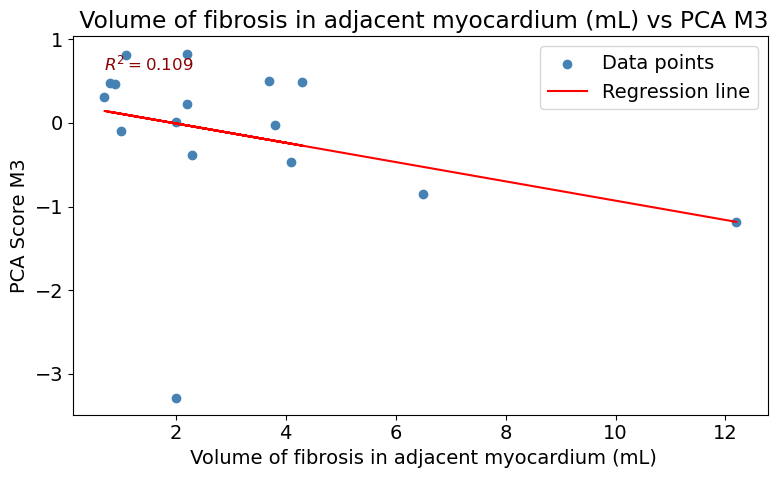


--- Regression: M4 vs  Volume of fibrosis in adjacent myocardium (mL) ---
                            OLS Regression Results                            
Dep. Variable:              PCA_Score   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                 -0.068
Method:                 Least Squares   F-statistic:                   0.04181
Date:                Fri, 08 Aug 2025   Prob (F-statistic):              0.841
Time:                        13:43:46   Log-Likelihood:                -21.992
No. Observations:                  16   AIC:                             47.98
Df Residuals:                      14   BIC:                             49.53
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                                      coef    std err          t      P>|t|      [0.025      0.975]
-------------------

/opt/homebrew/Caskroom/miniconda/base/lib/python3.13/site-packages/scipy/stats/_axis_nan_policy.py:430: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=16 observations were given.
  return hypotest_fun_in(*args, **kwds)


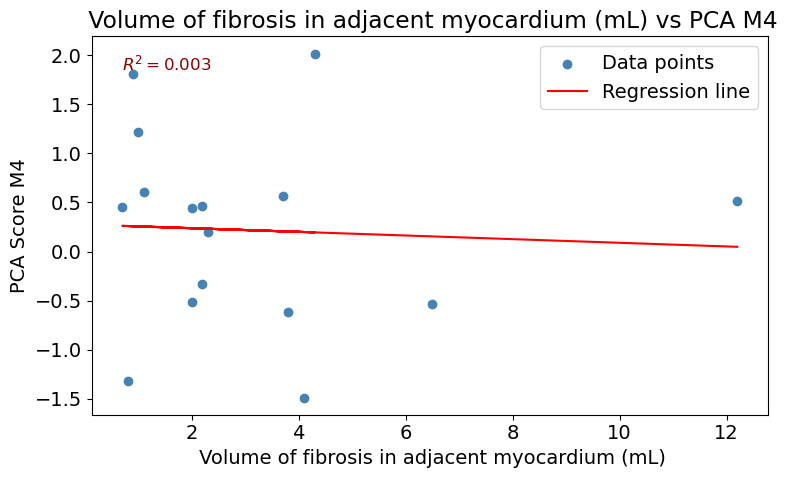


--- Regression: M5 vs  Volume of fibrosis in adjacent myocardium (mL) ---
                            OLS Regression Results                            
Dep. Variable:              PCA_Score   R-squared:                       0.013
Model:                            OLS   Adj. R-squared:                 -0.057
Method:                 Least Squares   F-statistic:                    0.1867
Date:                Fri, 08 Aug 2025   Prob (F-statistic):              0.672
Time:                        13:43:46   Log-Likelihood:                -13.216
No. Observations:                  16   AIC:                             30.43
Df Residuals:                      14   BIC:                             31.98
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                                      coef    std err          t      P>|t|      [0.025      0.975]
-------------------

/opt/homebrew/Caskroom/miniconda/base/lib/python3.13/site-packages/scipy/stats/_axis_nan_policy.py:430: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=16 observations were given.
  return hypotest_fun_in(*args, **kwds)


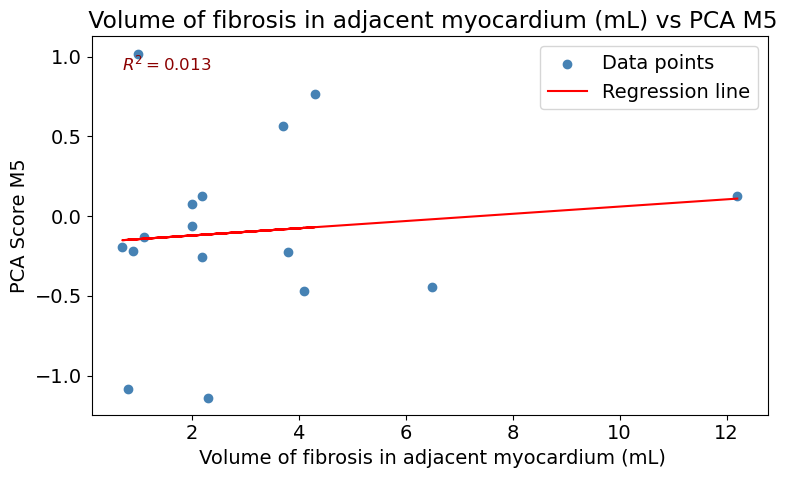


--- Regression: M6 vs  Volume of fibrosis in adjacent myocardium (mL) ---
                            OLS Regression Results                            
Dep. Variable:              PCA_Score   R-squared:                       0.106
Model:                            OLS   Adj. R-squared:                  0.043
Method:                 Least Squares   F-statistic:                     1.668
Date:                Fri, 08 Aug 2025   Prob (F-statistic):              0.217
Time:                        13:43:47   Log-Likelihood:                -17.370
No. Observations:                  16   AIC:                             38.74
Df Residuals:                      14   BIC:                             40.29
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                                      coef    std err          t      P>|t|      [0.025      0.975]
-------------------

/opt/homebrew/Caskroom/miniconda/base/lib/python3.13/site-packages/scipy/stats/_axis_nan_policy.py:430: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=16 observations were given.
  return hypotest_fun_in(*args, **kwds)


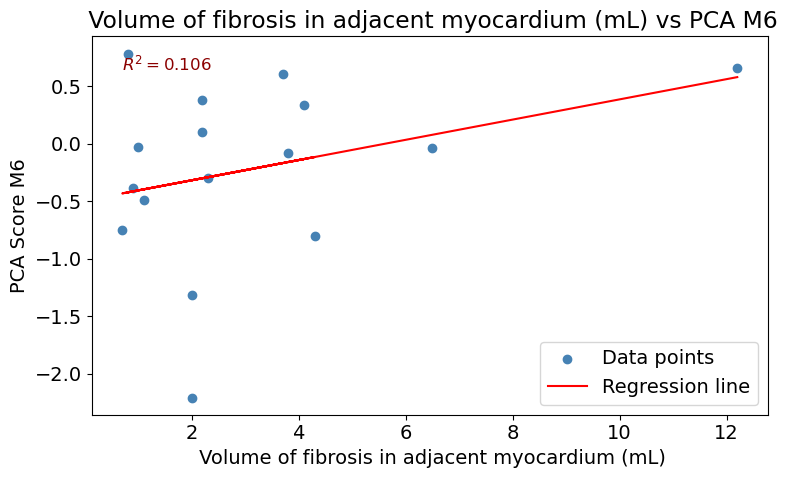

In [12]:
# Loop over PCA modes
for mode in ["M1", "M2", "M3", "M4", "M5", "M6"]:
    plot_pca_vs_clinical(
        pca_scores=pca_scores,
        mode_name=mode,
        clinical_data=clinical_data,
        clinical_var="CMR_LGE_Myo_adjacent_ml",
        clinical_label=" Volume of fibrosis in adjacent myocardium (mL)"
    )


--- Regression: M1 vs Ejection fraction % ---
                            OLS Regression Results                            
Dep. Variable:              PCA_Score   R-squared:                       0.012
Model:                            OLS   Adj. R-squared:                 -0.006
Method:                 Least Squares   F-statistic:                    0.6702
Date:                Fri, 08 Aug 2025   Prob (F-statistic):              0.417
Time:                        13:45:19   Log-Likelihood:                -80.393
No. Observations:                  57   AIC:                             164.8
Df Residuals:                      55   BIC:                             168.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------

/var/folders/6_/96w34l6d0xq8s4p3bdksz4gnh1qkjq/T/ipykernel_17986/4057304757.py:61: UserWarning: Glyph 57473 (\ue081) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/6_/96w34l6d0xq8s4p3bdksz4gnh1qkjq/T/ipykernel_17986/4057304757.py:61: UserWarning: Glyph 57474 (\ue082) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/opt/homebrew/Caskroom/miniconda/base/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 57473 (\ue081) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/homebrew/Caskroom/miniconda/base/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 57474 (\ue082) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


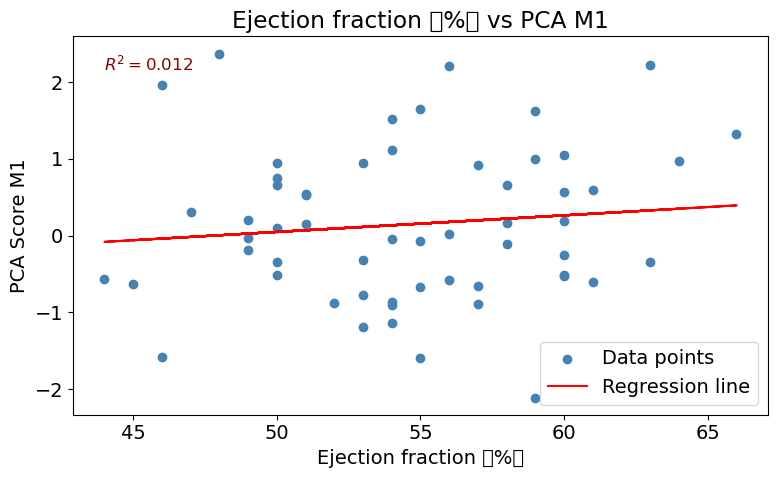


--- Regression: M2 vs Ejection fraction % ---
                            OLS Regression Results                            
Dep. Variable:              PCA_Score   R-squared:                       0.033
Model:                            OLS   Adj. R-squared:                  0.016
Method:                 Least Squares   F-statistic:                     1.900
Date:                Fri, 08 Aug 2025   Prob (F-statistic):              0.174
Time:                        13:45:19   Log-Likelihood:                -77.341
No. Observations:                  57   AIC:                             158.7
Df Residuals:                      55   BIC:                             162.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------

/var/folders/6_/96w34l6d0xq8s4p3bdksz4gnh1qkjq/T/ipykernel_17986/4057304757.py:61: UserWarning: Glyph 57473 (\ue081) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/6_/96w34l6d0xq8s4p3bdksz4gnh1qkjq/T/ipykernel_17986/4057304757.py:61: UserWarning: Glyph 57474 (\ue082) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/opt/homebrew/Caskroom/miniconda/base/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 57473 (\ue081) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/homebrew/Caskroom/miniconda/base/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 57474 (\ue082) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


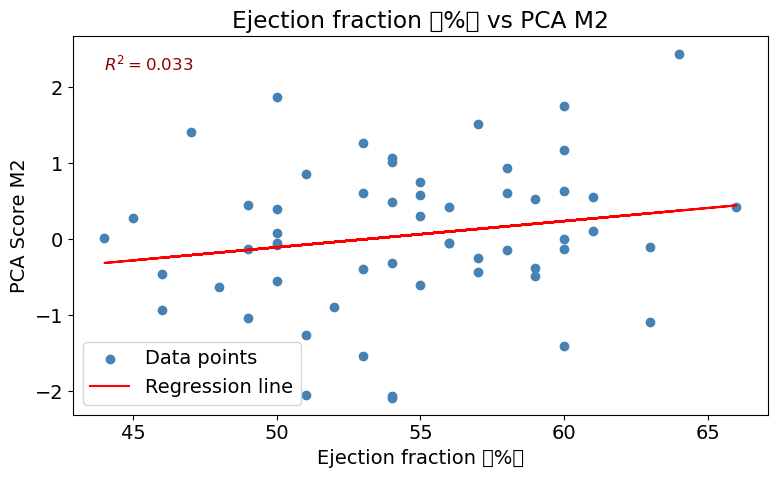


--- Regression: M3 vs Ejection fraction % ---
                            OLS Regression Results                            
Dep. Variable:              PCA_Score   R-squared:                       0.097
Model:                            OLS   Adj. R-squared:                  0.080
Method:                 Least Squares   F-statistic:                     5.875
Date:                Fri, 08 Aug 2025   Prob (F-statistic):             0.0187
Time:                        13:45:19   Log-Likelihood:                -69.342
No. Observations:                  57   AIC:                             142.7
Df Residuals:                      55   BIC:                             146.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------

/var/folders/6_/96w34l6d0xq8s4p3bdksz4gnh1qkjq/T/ipykernel_17986/4057304757.py:61: UserWarning: Glyph 57473 (\ue081) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/6_/96w34l6d0xq8s4p3bdksz4gnh1qkjq/T/ipykernel_17986/4057304757.py:61: UserWarning: Glyph 57474 (\ue082) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/opt/homebrew/Caskroom/miniconda/base/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 57473 (\ue081) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/homebrew/Caskroom/miniconda/base/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 57474 (\ue082) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


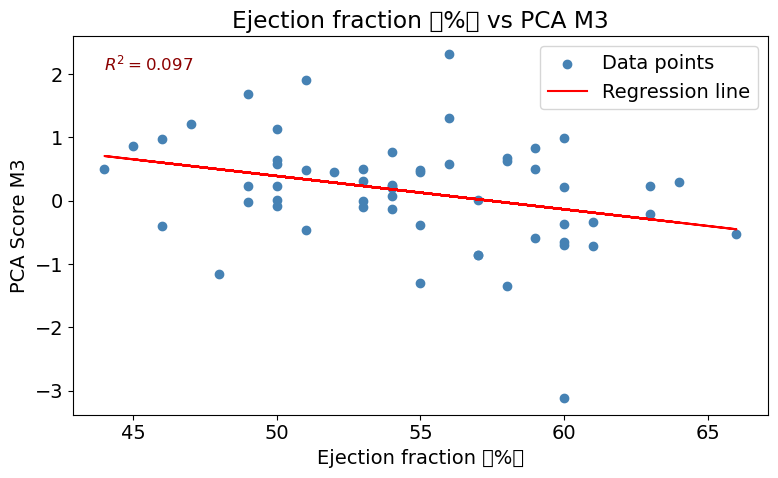


--- Regression: M4 vs Ejection fraction % ---
                            OLS Regression Results                            
Dep. Variable:              PCA_Score   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                 -0.016
Method:                 Least Squares   F-statistic:                    0.1371
Date:                Fri, 08 Aug 2025   Prob (F-statistic):              0.713
Time:                        13:45:19   Log-Likelihood:                -73.201
No. Observations:                  57   AIC:                             150.4
Df Residuals:                      55   BIC:                             154.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------

/var/folders/6_/96w34l6d0xq8s4p3bdksz4gnh1qkjq/T/ipykernel_17986/4057304757.py:61: UserWarning: Glyph 57473 (\ue081) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/6_/96w34l6d0xq8s4p3bdksz4gnh1qkjq/T/ipykernel_17986/4057304757.py:61: UserWarning: Glyph 57474 (\ue082) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/opt/homebrew/Caskroom/miniconda/base/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 57473 (\ue081) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/homebrew/Caskroom/miniconda/base/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 57474 (\ue082) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


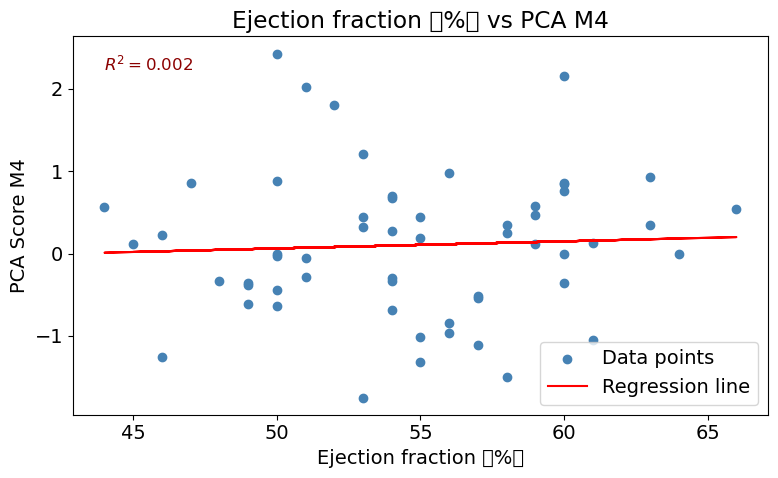


--- Regression: M5 vs Ejection fraction % ---
                            OLS Regression Results                            
Dep. Variable:              PCA_Score   R-squared:                       0.015
Model:                            OLS   Adj. R-squared:                 -0.002
Method:                 Least Squares   F-statistic:                    0.8646
Date:                Fri, 08 Aug 2025   Prob (F-statistic):              0.357
Time:                        13:45:19   Log-Likelihood:                -78.958
No. Observations:                  57   AIC:                             161.9
Df Residuals:                      55   BIC:                             166.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------

/var/folders/6_/96w34l6d0xq8s4p3bdksz4gnh1qkjq/T/ipykernel_17986/4057304757.py:61: UserWarning: Glyph 57473 (\ue081) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/6_/96w34l6d0xq8s4p3bdksz4gnh1qkjq/T/ipykernel_17986/4057304757.py:61: UserWarning: Glyph 57474 (\ue082) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/opt/homebrew/Caskroom/miniconda/base/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 57473 (\ue081) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/homebrew/Caskroom/miniconda/base/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 57474 (\ue082) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


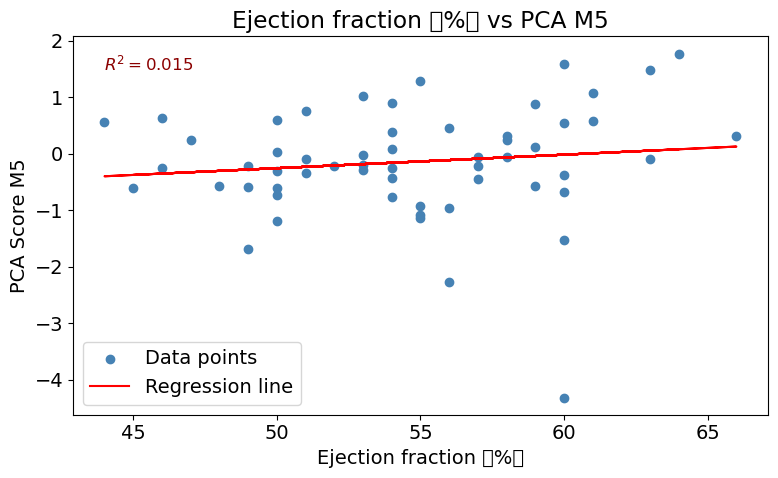


--- Regression: M6 vs Ejection fraction % ---
                            OLS Regression Results                            
Dep. Variable:              PCA_Score   R-squared:                       0.039
Model:                            OLS   Adj. R-squared:                  0.021
Method:                 Least Squares   F-statistic:                     2.213
Date:                Fri, 08 Aug 2025   Prob (F-statistic):              0.143
Time:                        13:45:19   Log-Likelihood:                -77.670
No. Observations:                  57   AIC:                             159.3
Df Residuals:                      55   BIC:                             163.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------

/var/folders/6_/96w34l6d0xq8s4p3bdksz4gnh1qkjq/T/ipykernel_17986/4057304757.py:61: UserWarning: Glyph 57473 (\ue081) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/6_/96w34l6d0xq8s4p3bdksz4gnh1qkjq/T/ipykernel_17986/4057304757.py:61: UserWarning: Glyph 57474 (\ue082) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/opt/homebrew/Caskroom/miniconda/base/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 57473 (\ue081) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/homebrew/Caskroom/miniconda/base/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 57474 (\ue082) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


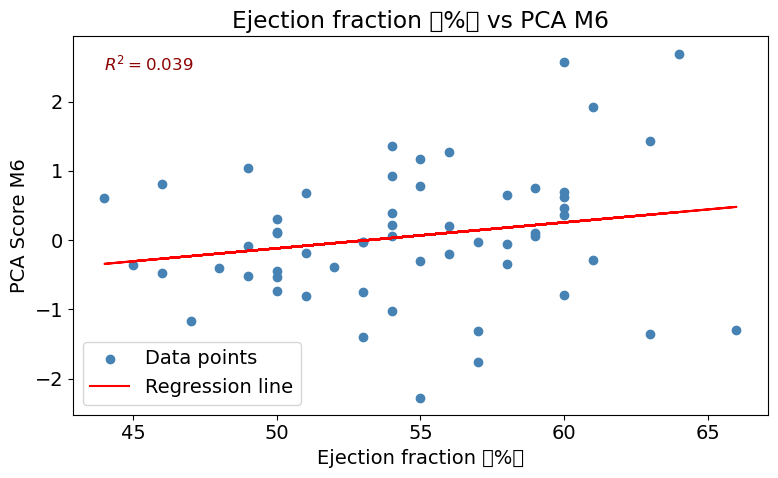

In [13]:
# Loop over PCA modes
for mode in ["M1", "M2", "M3", "M4", "M5", "M6"]:
    plot_pca_vs_clinical(
        pca_scores=pca_scores,
        mode_name=mode,
        clinical_data=clinical_data,
        clinical_var="CMR_EF_Monica",
        clinical_label="Ejection fraction %"
    )


--- Regression: M1 vs  Degree of inferolateral MAD (in mm) ---
                            OLS Regression Results                            
Dep. Variable:              PCA_Score   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.012
Method:                 Least Squares   F-statistic:                   0.05818
Date:                Fri, 08 Aug 2025   Prob (F-statistic):              0.810
Time:                        13:59:28   Log-Likelihood:                -112.29
No. Observations:                  78   AIC:                             228.6
Df Residuals:                      76   BIC:                             233.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                           coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

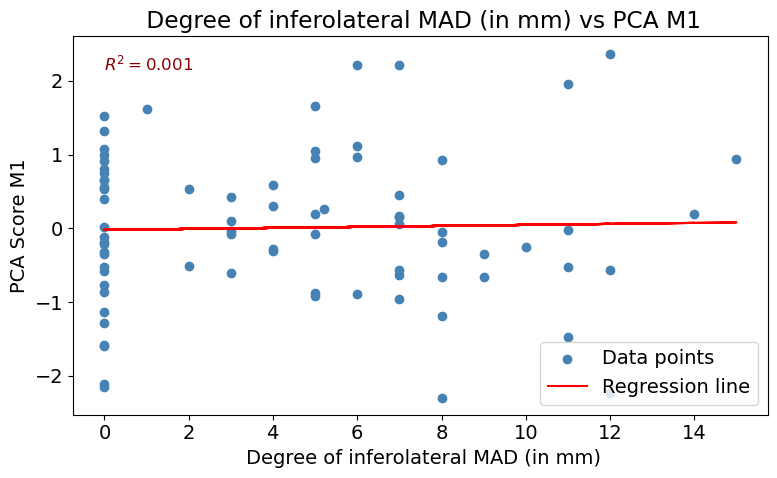


--- Regression: M2 vs  Degree of inferolateral MAD (in mm) ---
                            OLS Regression Results                            
Dep. Variable:              PCA_Score   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                 -0.006
Method:                 Least Squares   F-statistic:                    0.5107
Date:                Fri, 08 Aug 2025   Prob (F-statistic):              0.477
Time:                        13:59:28   Log-Likelihood:                -110.74
No. Observations:                  78   AIC:                             225.5
Df Residuals:                      76   BIC:                             230.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                           coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

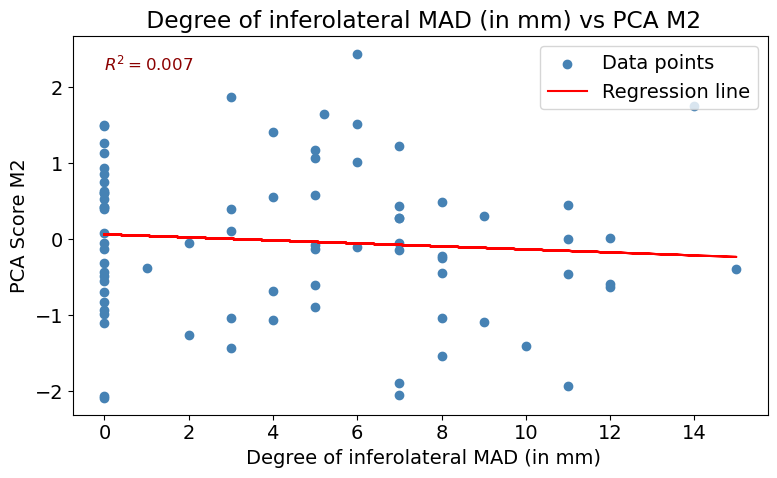


--- Regression: M3 vs  Degree of inferolateral MAD (in mm) ---
                            OLS Regression Results                            
Dep. Variable:              PCA_Score   R-squared:                       0.014
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1.084
Date:                Fri, 08 Aug 2025   Prob (F-statistic):              0.301
Time:                        13:59:28   Log-Likelihood:                -107.66
No. Observations:                  78   AIC:                             219.3
Df Residuals:                      76   BIC:                             224.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                           coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

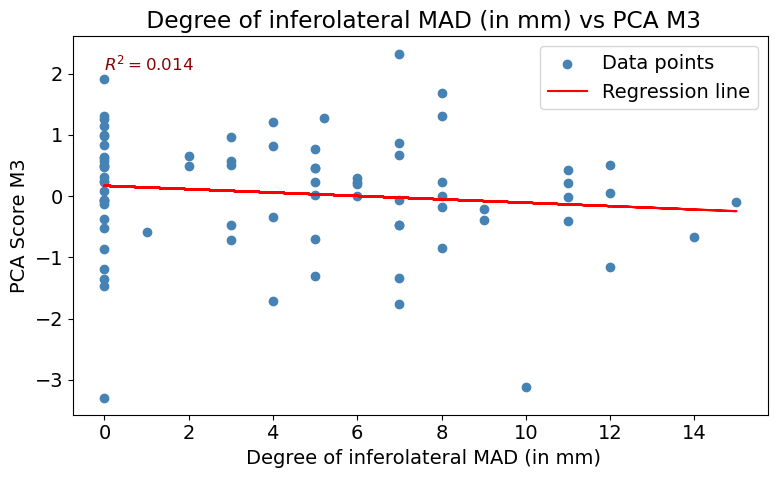


--- Regression: M4 vs  Degree of inferolateral MAD (in mm) ---
                            OLS Regression Results                            
Dep. Variable:              PCA_Score   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                 -0.006
Method:                 Least Squares   F-statistic:                    0.5272
Date:                Fri, 08 Aug 2025   Prob (F-statistic):              0.470
Time:                        13:59:28   Log-Likelihood:                -110.90
No. Observations:                  78   AIC:                             225.8
Df Residuals:                      76   BIC:                             230.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                           coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

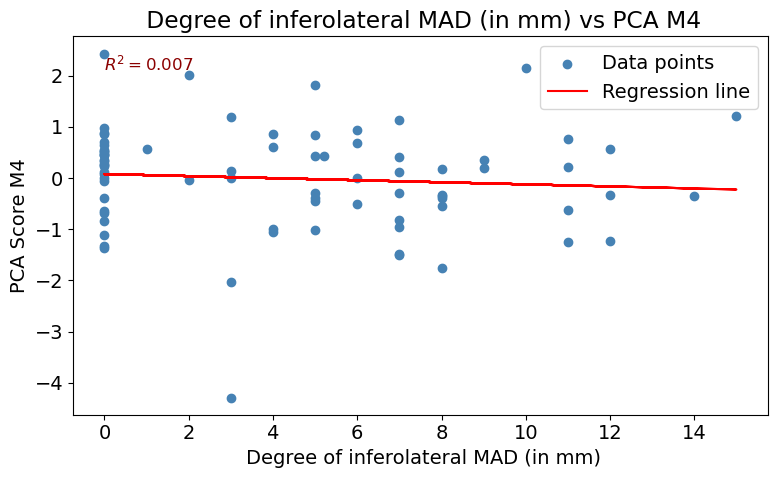


--- Regression: M5 vs  Degree of inferolateral MAD (in mm) ---
                            OLS Regression Results                            
Dep. Variable:              PCA_Score   R-squared:                       0.015
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     1.163
Date:                Fri, 08 Aug 2025   Prob (F-statistic):              0.284
Time:                        13:59:28   Log-Likelihood:                -108.49
No. Observations:                  78   AIC:                             221.0
Df Residuals:                      76   BIC:                             225.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                           coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

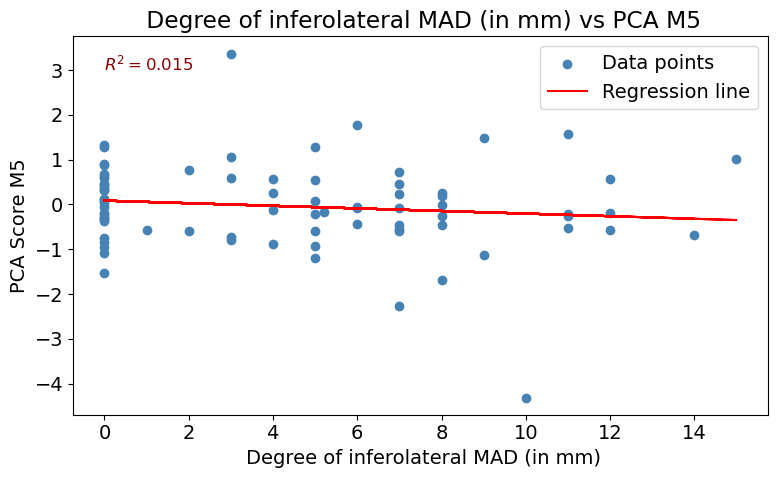


--- Regression: M6 vs  Degree of inferolateral MAD (in mm) ---
                            OLS Regression Results                            
Dep. Variable:              PCA_Score   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                 -0.004
Method:                 Least Squares   F-statistic:                    0.6921
Date:                Fri, 08 Aug 2025   Prob (F-statistic):              0.408
Time:                        13:59:28   Log-Likelihood:                -109.73
No. Observations:                  78   AIC:                             223.5
Df Residuals:                      76   BIC:                             228.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                           coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

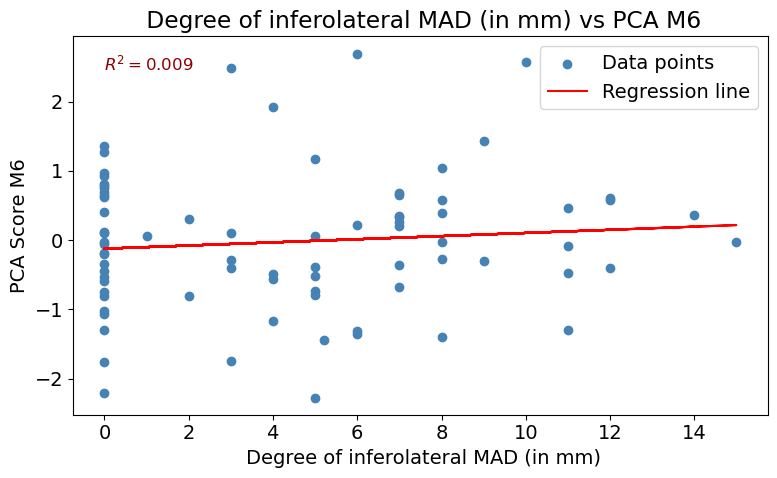

In [14]:


# Create combined MAD variable
clinical_data["MAD_combined"] = (
    clinical_data["CMR_MAD_3_CH"]
    .fillna(clinical_data["MADplax_length"])
)

# Drop patients with neither value
clinical_data = clinical_data.dropna(subset=["MAD_combined"])


# Loop over PCA modes
for mode in ["M1", "M2", "M3", "M4", "M5", "M6"]:
    plot_pca_vs_clinical(
        pca_scores=pca_scores,
        mode_name=mode,
        clinical_data=clinical_data,
        clinical_var="MAD_combined",
        clinical_label=" Degree of inferolateral MAD (in mm)"
    )


--- Regression: M1 vs Mitral Annular Disjunction (MAD) Measurements from echo ---
                            OLS Regression Results                            
Dep. Variable:              PCA_Score   R-squared:                       0.013
Model:                            OLS   Adj. R-squared:                 -0.015
Method:                 Least Squares   F-statistic:                    0.4575
Date:                Fri, 08 Aug 2025   Prob (F-statistic):              0.503
Time:                        14:01:55   Log-Likelihood:                -55.793
No. Observations:                  37   AIC:                             115.6
Df Residuals:                      35   BIC:                             118.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                                              coef    std err          t      P>|t|      [0.025      0.975]
---

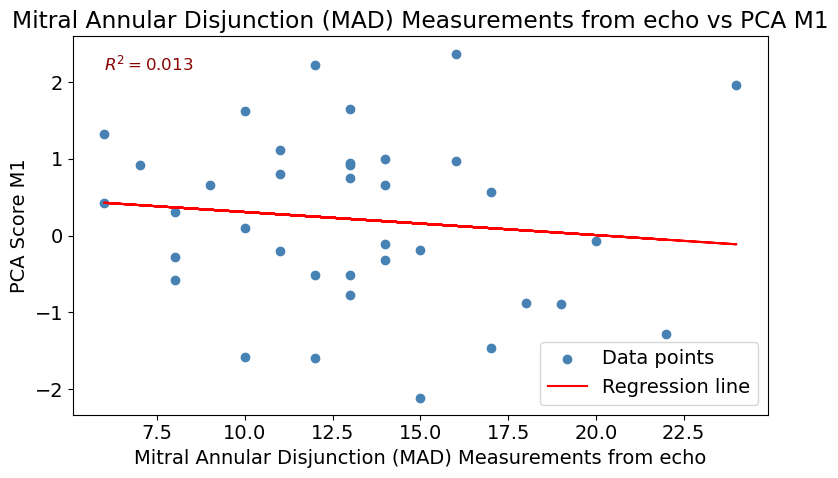


--- Regression: M2 vs Mitral Annular Disjunction (MAD) Measurements from echo ---
                            OLS Regression Results                            
Dep. Variable:              PCA_Score   R-squared:                       0.016
Model:                            OLS   Adj. R-squared:                 -0.012
Method:                 Least Squares   F-statistic:                    0.5640
Date:                Fri, 08 Aug 2025   Prob (F-statistic):              0.458
Time:                        14:01:55   Log-Likelihood:                -50.655
No. Observations:                  37   AIC:                             105.3
Df Residuals:                      35   BIC:                             108.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                                              coef    std err          t      P>|t|      [0.025      0.975]
---

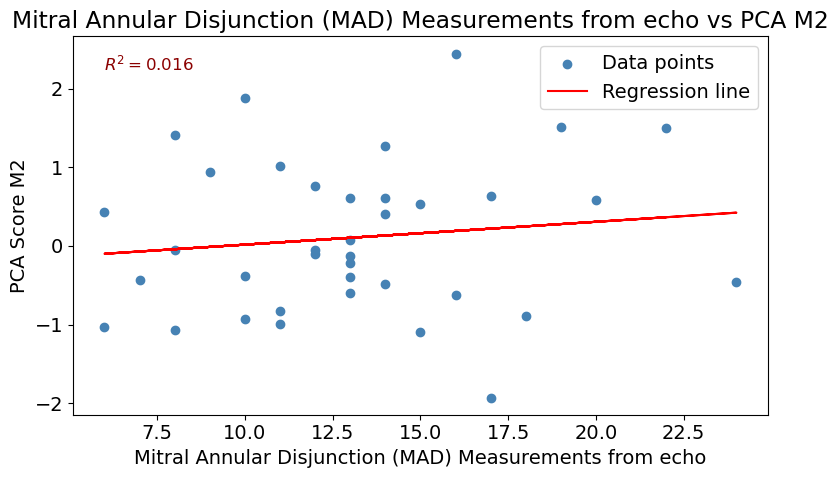


--- Regression: M3 vs Mitral Annular Disjunction (MAD) Measurements from echo ---
                            OLS Regression Results                            
Dep. Variable:              PCA_Score   R-squared:                       0.092
Model:                            OLS   Adj. R-squared:                  0.066
Method:                 Least Squares   F-statistic:                     3.553
Date:                Fri, 08 Aug 2025   Prob (F-statistic):             0.0678
Time:                        14:01:55   Log-Likelihood:                -47.841
No. Observations:                  37   AIC:                             99.68
Df Residuals:                      35   BIC:                             102.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                                              coef    std err          t      P>|t|      [0.025      0.975]
---

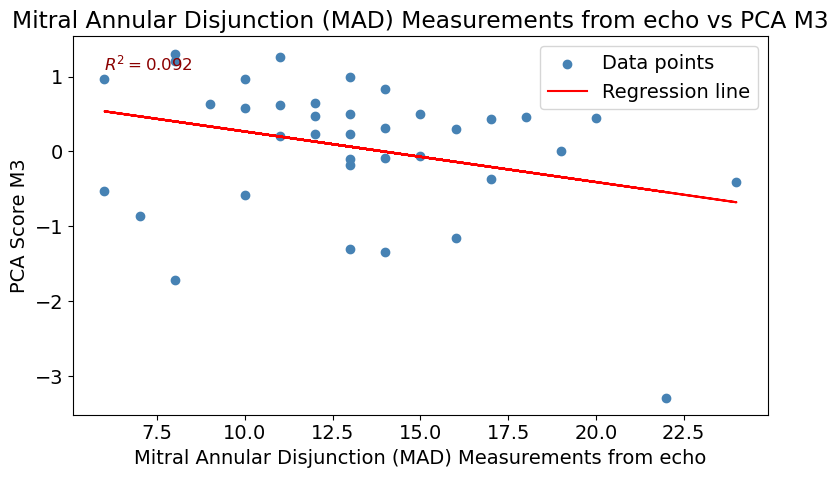


--- Regression: M4 vs Mitral Annular Disjunction (MAD) Measurements from echo ---
                            OLS Regression Results                            
Dep. Variable:              PCA_Score   R-squared:                       0.011
Model:                            OLS   Adj. R-squared:                 -0.017
Method:                 Least Squares   F-statistic:                    0.4054
Date:                Fri, 08 Aug 2025   Prob (F-statistic):              0.528
Time:                        14:01:55   Log-Likelihood:                -44.895
No. Observations:                  37   AIC:                             93.79
Df Residuals:                      35   BIC:                             97.01
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                                              coef    std err          t      P>|t|      [0.025      0.975]
---

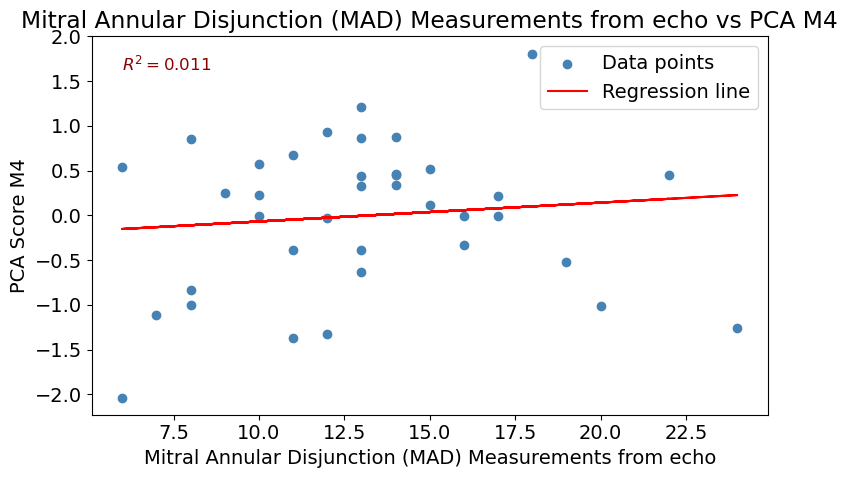


--- Regression: M5 vs Mitral Annular Disjunction (MAD) Measurements from echo ---
                            OLS Regression Results                            
Dep. Variable:              PCA_Score   R-squared:                       0.018
Model:                            OLS   Adj. R-squared:                 -0.010
Method:                 Least Squares   F-statistic:                    0.6314
Date:                Fri, 08 Aug 2025   Prob (F-statistic):              0.432
Time:                        14:01:55   Log-Likelihood:                -48.596
No. Observations:                  37   AIC:                             101.2
Df Residuals:                      35   BIC:                             104.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                                              coef    std err          t      P>|t|      [0.025      0.975]
---

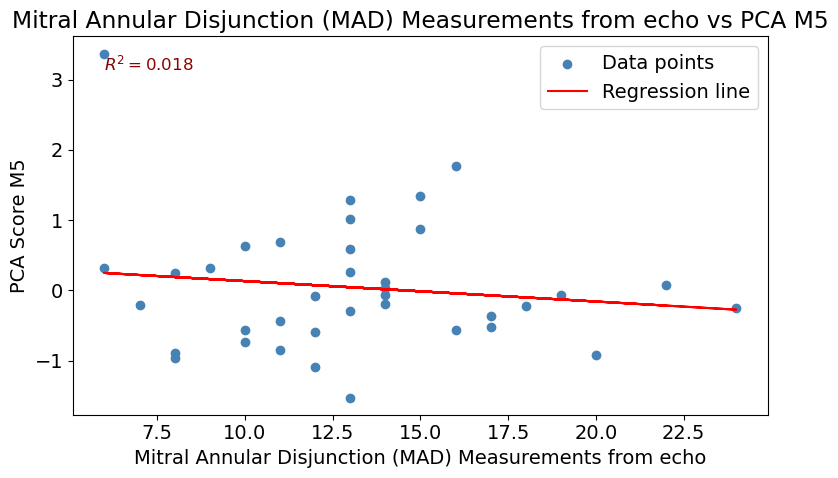


--- Regression: M6 vs Mitral Annular Disjunction (MAD) Measurements from echo ---
                            OLS Regression Results                            
Dep. Variable:              PCA_Score   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.028
Method:                 Least Squares   F-statistic:                  0.005729
Date:                Fri, 08 Aug 2025   Prob (F-statistic):              0.940
Time:                        14:01:55   Log-Likelihood:                -52.761
No. Observations:                  37   AIC:                             109.5
Df Residuals:                      35   BIC:                             112.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                                              coef    std err          t      P>|t|      [0.025      0.975]
---

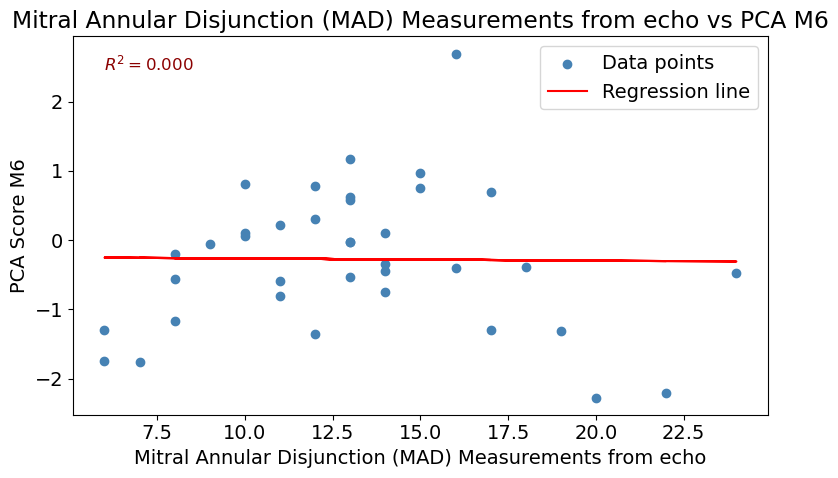

In [15]:


# Loop over PCA modes
for mode in ["M1", "M2", "M3", "M4", "M5", "M6"]:
    plot_pca_vs_clinical(
        pca_scores=pca_scores,
        mode_name=mode,
        clinical_data=clinical_data,
        clinical_var="TDI_Smark_lat",
        clinical_label="Mitral Annular Disjunction (MAD) Measurements from echo"
    )